## 0 – Setup & 1 – Load Data

In this step, we will:
- Import required libraries  
- Define `SUBSET_FRAC` (fraction of each split for EDA)  
- Load and down-sample the train/validation/test splits  
- Display the number of examples in each split

In [2]:
import random
from datasets import load_dataset
import pandas as pd

# Fraction of each split to load (1.0 for full dataset)
SUBSET_FRAC = 1
DATASET = "alexfabbri/multi_news"

random.seed(42)

def load_split(name: str, frac: float):
    ds = load_dataset(DATASET, split=name)
    if 0.0 < frac < 1.0:
        ds = ds.shuffle(seed=42).select(range(int(len(ds) * frac)))
    return ds

# Load and down-sample
train_ds = load_split("train", SUBSET_FRAC)
val_ds   = load_split("validation", SUBSET_FRAC)
test_ds  = load_split("test", SUBSET_FRAC)

# Summarize sizes
sizes_df = pd.DataFrame({
    "split": ["train", "validation", "test"],
    "num_examples": [len(train_ds), len(val_ds), len(test_ds)]
})

sizes_df


,split,num_examples
0,train,44972
1,validation,5622
2,test,5622


## 2 – Raw-Text Glimpse

Pick a random example from the sampled train split and display its document (first 500 chars) and reference summary.


In [6]:
import random

idx = random.randrange(len(train_ds))
doc = train_ds[idx]["document"]
summ = train_ds[idx]["summary"]

print(f"Example index: {idx}\n")
print("DOCUMENT (first 500 chars):\n", doc[:500].replace("\n", " "), "...\n")
print("REFERENCE SUMMARY:\n", summ)

Example index: 41905

DOCUMENT (first 500 chars):
         We’ve all been told to eat our vegetables, and even if we don’t like it, we know they’re good for us. But a new study shows just how good for our longevity they may be.     Seven or more portions of fruit and vegetables a day can lower your risk of dying by an astonishing 42%, according to a new study published in the Journal of Epidemiology & Community Health. The more fruits and vegetables the participants ate, the less likely they were to die at any age, and the protective benefit inc ...

REFERENCE SUMMARY:
 – Even if you're a proud consumer of five servings of fruits and vegetables daily, you're not getting enough, an extensive British study suggests. And steer clear of the canned stuff. University College London researchers reviewed the diets of 65,000 people; they found that those who ate more fresh fruits and vegetables tended to live longer, and the magic threshold seemed to be seven-plus servings every day. Those who 

## 3 – Length Statistics

Compute character‐ and token‐level lengths for documents and summaries in the sampled train split, then display descriptive statistics (mean, median, min, max, std).


In [7]:
# %%
import pandas as pd

def compute_length_stats(dataset):
    records = {
        "char_len_doc": [],
        "token_len_doc": [],
        "char_len_sum": [],
        "token_len_sum": []
    }
    for ex in dataset:
        doc = ex["document"]
        summ = ex["summary"]
        records["char_len_doc"].append(len(doc))
        records["token_len_doc"].append(len(doc.split()))
        records["char_len_sum"].append(len(summ))
        records["token_len_sum"].append(len(summ.split()))
    return pd.DataFrame(records)

# Compute on train subset
train_len_df = compute_length_stats(train_ds)

# Show descriptive stats
length_stats = train_len_df.describe().loc[["mean", "50%", "min", "max", "std"]]
length_stats


,char_len_doc,token_len_doc,char_len_sum,token_len_sum
mean,1.101772e+04,1794.376523,1300.303633,218.258138
50%,8.145000e+03,1326.000000,1320.000000,221.000000
min,0.000000e+00,0.000000,190.000000,34.000000
max,2.916289e+06,449621.000000,5910.000000,973.000000
std,1.929024e+04,3033.513260,405.910378,68.046933


## 4 – Compression Ratio

Compute and plot the ratio of summary token length to document token length, excluding any infinite or undefined values.


count    44964.000000
mean         0.210322
std          0.263464
min          0.000709
25%          0.101952
50%          0.157496
75%          0.245710
max         11.043478
Name: compression_ratio, dtype: float64


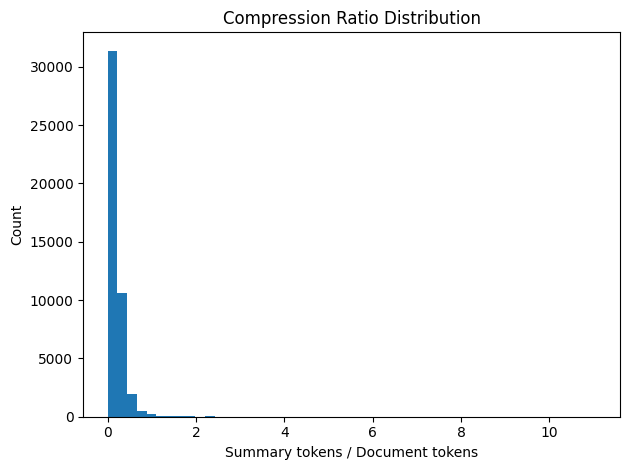

In [9]:
# %%
import numpy as np
import matplotlib.pyplot as plt

# Drop examples where document token length is zero
valid = train_len_df['token_len_doc'] > 0

# Compute compression ratio on valid rows
train_len_df = train_len_df[valid].copy()
train_len_df['compression_ratio'] = (
    train_len_df['token_len_sum'] / train_len_df['token_len_doc']
)

# Remove infinite or NaN ratios
finite_mask = np.isfinite(train_len_df['compression_ratio'])
train_len_df = train_len_df[finite_mask]

# Descriptive statistics
comp_stats = train_len_df['compression_ratio'].describe()
print(comp_stats)

# Plot histogram
plt.figure()
plt.hist(train_len_df['compression_ratio'], bins=50)
plt.title('Compression Ratio Distribution')
plt.xlabel('Summary tokens / Document tokens')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


## 5 – Word Frequency Distribution (20% Sample)

Sample 20% of `train_ds`, pre-clean once (stopwords removed), then compute and plot unigrams and Zipf.


In [11]:
import os, sys

# assume this notebook lives in <project>/notebooks/
proj_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if proj_root not in sys.path:
    sys.path.insert(0, proj_root)

print("Project root added to sys.path:", proj_root)

Project root added to sys.path: /s/chopin/l/grad/c837213756/Documents/multi_doc_summarization


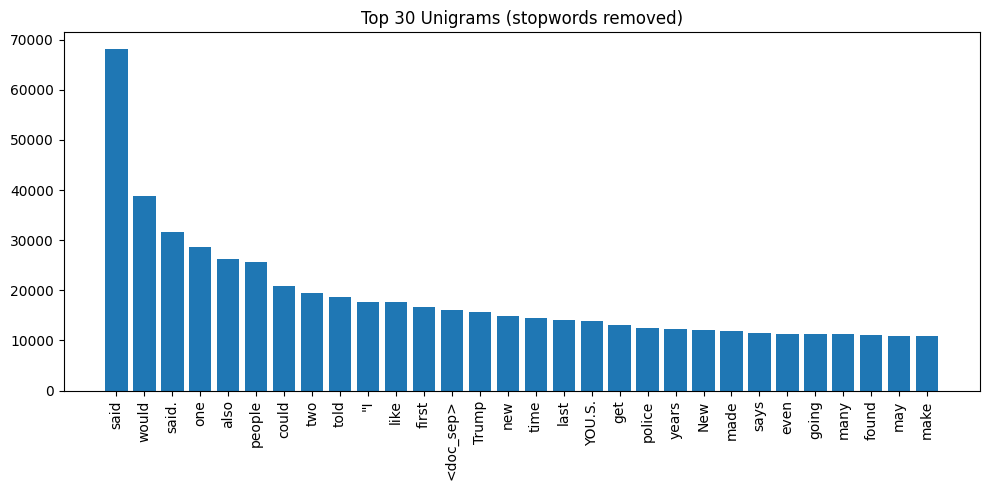

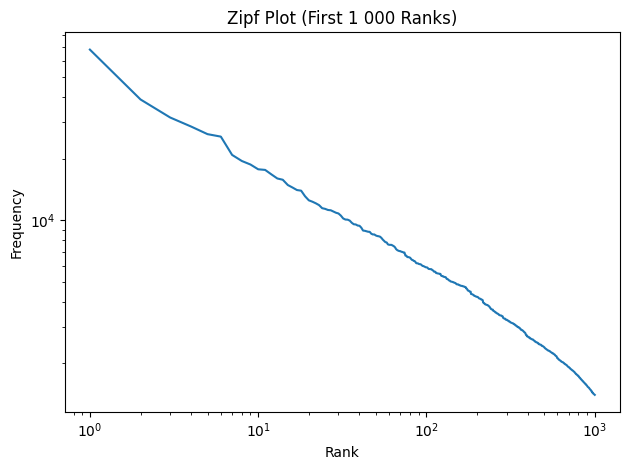

In [16]:
import random
from collections import Counter
import matplotlib.pyplot as plt
from src.utils import clean_text

# sample 20% of train_ds
ANALYSIS_FRAC = 0.2
n = int(len(train_ds) * ANALYSIS_FRAC)
idxs = random.sample(range(len(train_ds)), n)

# pre-clean documents (stopwords removed)
cleaned_docs = [
    clean_text(train_ds[i]["document"], remove_stopwords=True)
    for i in idxs
]

# unigram counts
unigram_counts = Counter()
for doc in cleaned_docs:
    unigram_counts.update(doc.split())

# top 30
top30 = unigram_counts.most_common(30)
words, freqs = zip(*top30)

plt.figure(figsize=(10,5))
plt.bar(words, freqs)
plt.xticks(rotation=90)
plt.title("Top 30 Unigrams (stopwords removed)")
plt.tight_layout()
plt.show()

# Zipf plot
freq_values = sorted(unigram_counts.values(), reverse=True)
ranks = range(1, len(freq_values)+1)
plt.figure()
plt.loglog(ranks[:1000], freq_values[:1000])
plt.title("Zipf Plot (First 1 000 Ranks)")
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [17]:
top30

[('said', 68062),
 ('would', 38853),
 ('said.', 31725),
 ('one', 28650),
 ('also', 26317),
 ('people', 25593),
 ('could', 20837),
 ('two', 19459),
 ('told', 18705),
 ('"I', 17730),
 ('like', 17606),
 ('first', 16729),
 ('<doc_sep>', 15988),
 ('Trump', 15763),
 ('new', 14856),
 ('time', 14443),
 ('last', 14040),
 ('YOU.S.', 13942),
 ('get', 13085),
 ('police', 12508),
 ('years', 12316),
 ('New', 12097),
 ('made', 11853),
 ('says', 11451),
 ('even', 11363),
 ('going', 11222),
 ('many', 11184),
 ('found', 11029),
 ('may', 10878),
 ('make', 10789)]

## 6 – N-gram Frequency (20% Sample)

Reuse the same 20% sample and pre-cleaned texts to compute top-20 bi-grams and tri-grams.


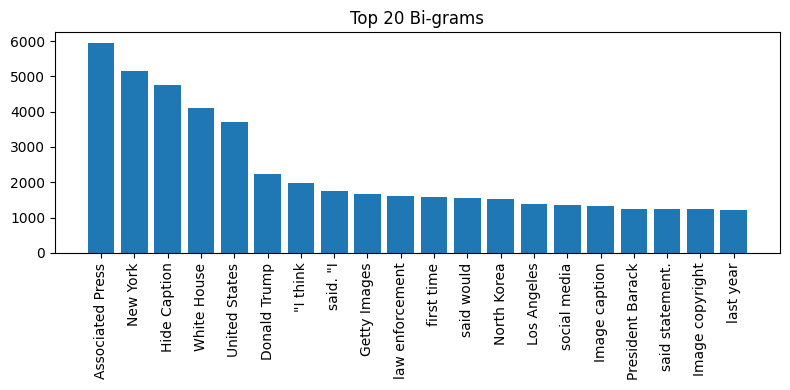

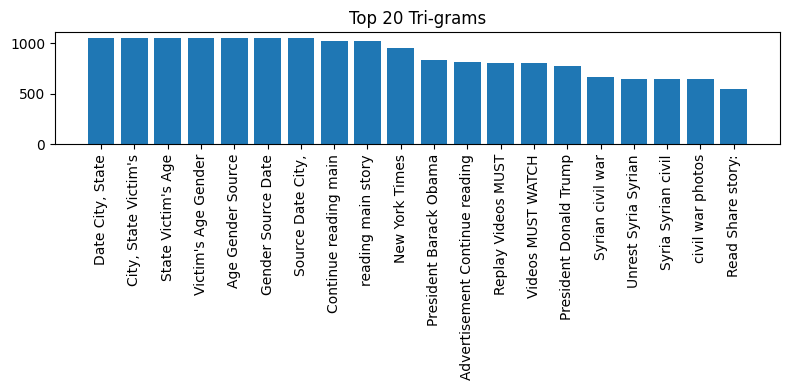

In [18]:
# %%
from collections import Counter
import matplotlib.pyplot as plt

def extract_ngrams(tokens, n):
    return zip(*[tokens[i:] for i in range(n)])

# tokenize cleaned_docs once
token_lists = [doc.split() for doc in cleaned_docs]

# count n-grams
bigram_counts = Counter()
trigram_counts = Counter()
for tokens in token_lists:
    bigram_counts.update(extract_ngrams(tokens, 2))
    trigram_counts.update(extract_ngrams(tokens, 3))

# top 20
top20_bg = bigram_counts.most_common(20)
top20_tg = trigram_counts.most_common(20)

# plot bi-grams
labels_bg = [" ".join(bg) for bg, _ in top20_bg]
freq_bg   = [cnt for _, cnt in top20_bg]
plt.figure(figsize=(8,4))
plt.bar(labels_bg, freq_bg)
plt.xticks(rotation=90)
plt.title("Top 20 Bi-grams")
plt.tight_layout()
plt.show()

# plot tri-grams
labels_tg = [" ".join(tg) for tg, _ in top20_tg]
freq_tg   = [cnt for _, cnt in top20_tg]
plt.figure(figsize=(8,4))
plt.bar(labels_tg, freq_tg)
plt.xticks(rotation=90)
plt.title("Top 20 Tri-grams")
plt.tight_layout()
plt.show()


In [19]:
top20_bg

[(('Associated', 'Press'), 5954),
 (('New', 'York'), 5166),
 (('Hide', 'Caption'), 4745),
 (('White', 'House'), 4117),
 (('United', 'States'), 3708),
 (('Donald', 'Trump'), 2227),
 (('"I', 'think'), 1971),
 (('said.', '"I'), 1753),
 (('Getty', 'Images'), 1657),
 (('law', 'enforcement'), 1600),
 (('first', 'time'), 1587),
 (('said', 'would'), 1564),
 (('North', 'Korea'), 1516),
 (('Los', 'Angeles'), 1379),
 (('social', 'media'), 1352),
 (('Image', 'caption'), 1314),
 (('President', 'Barack'), 1240),
 (('said', 'statement.'), 1238),
 (('Image', 'copyright'), 1235),
 (('last', 'year'), 1217)]

In [20]:
top20_tg

[(('Date', 'City,', 'State'), 1057),
 (('City,', 'State', "Victim's"), 1057),
 (('State', "Victim's", 'Age'), 1057),
 (("Victim's", 'Age', 'Gender'), 1057),
 (('Age', 'Gender', 'Source'), 1057),
 (('Gender', 'Source', 'Date'), 1056),
 (('Source', 'Date', 'City,'), 1056),
 (('Continue', 'reading', 'main'), 1023),
 (('reading', 'main', 'story'), 1023),
 (('New', 'York', 'Times'), 956),
 (('President', 'Barack', 'Obama'), 839),
 (('Advertisement', 'Continue', 'reading'), 811),
 (('Replay', 'Videos', 'MUST'), 807),
 (('Videos', 'MUST', 'WATCH'), 807),
 (('President', 'Donald', 'Trump'), 780),
 (('Syrian', 'civil', 'war'), 664),
 (('Unrest', 'Syria', 'Syrian'), 652),
 (('Syria', 'Syrian', 'civil'), 652),
 (('civil', 'war', 'photos'), 652),
 (('Read', 'Share', 'story:'), 545)]

## 7 – Redundancy Metrics

Compute redundancy on the 20% sample:  
- **Sentence duplication rate**: fraction of repeated sentences per document  
- **Token duplication rate**: fraction of repeated tokens per document  

Display descriptive statistics and histograms for both metrics.


      sent_dup_rate  token_dup_rate
mean       0.014158        0.340803
50%        0.000000        0.339630
min        0.000000        0.000000
max        0.633803        0.970112
std        0.049185        0.102251


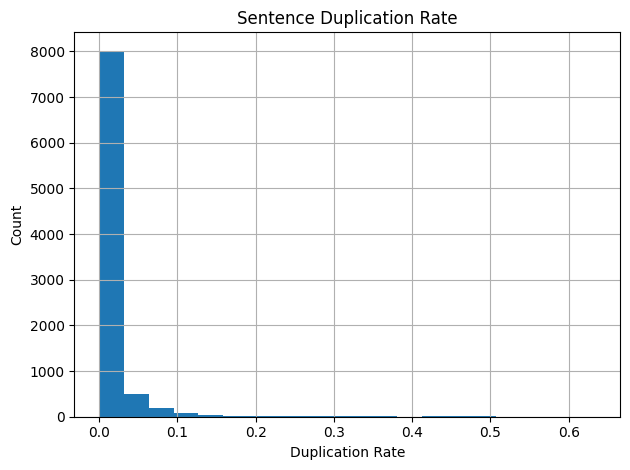

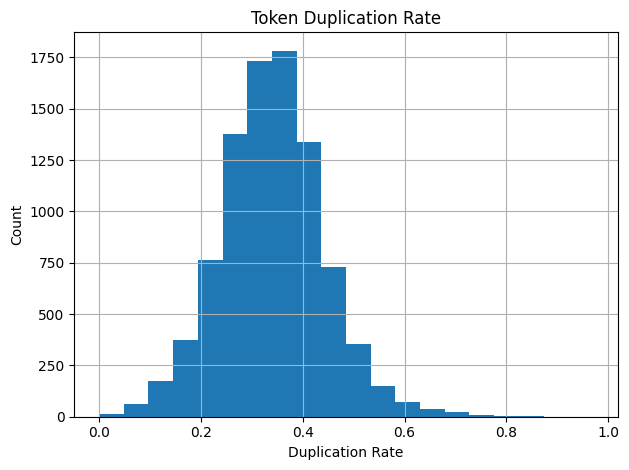

In [21]:
# %%
import nltk; nltk.download('punkt', quiet=True)
from nltk.tokenize import sent_tokenize
import pandas as pd
import matplotlib.pyplot as plt

# Reuse the same 20% sample indices (idxs) and token_lists from §§5–6
docs_sample = [train_ds[i]["document"] for i in idxs]

sent_dup_rates = []
token_dup_rates = []
for doc, tokens in zip(docs_sample, token_lists):
    # Sentence-level duplication
    sents   = sent_tokenize(doc)
    total_s = len(sents)
    uniq_s  = len({s.strip().lower() for s in sents})
    sent_dup_rates.append((total_s - uniq_s)/total_s if total_s>0 else 0.0)
    # Token-level duplication
    total_t = len(tokens)
    uniq_t  = len(set(tokens))
    token_dup_rates.append((total_t - uniq_t)/total_t if total_t>0 else 0.0)

df_dup = pd.DataFrame({
    "sent_dup_rate":  sent_dup_rates,
    "token_dup_rate": token_dup_rates
})

# Descriptive statistics
print(df_dup.describe().loc[['mean','50%','min','max','std']])

# Histograms
plt.figure()
df_dup['sent_dup_rate'].hist(bins=20)
plt.title('Sentence Duplication Rate')
plt.xlabel('Duplication Rate')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

plt.figure()
df_dup['token_dup_rate'].hist(bins=20)
plt.title('Token Duplication Rate')
plt.xlabel('Duplication Rate')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


## 8 – Effect of Cleaning

Assess the impact of our cleaning pipeline on the 20% sample by measuring:
- Token count reduction (%)  
- Vocabulary size change (%)  
- Garbage token removal rate (%)  


      reduction_pct  vocab_change_pct  garbage_removed_pct
mean      40.388762        -16.524329            96.996117
50%       40.439879        -15.964048           100.000000
min      -87.319069        -52.351314             0.000000
max       68.504832         45.024876           100.000000
std        3.848642          4.785680            11.174021


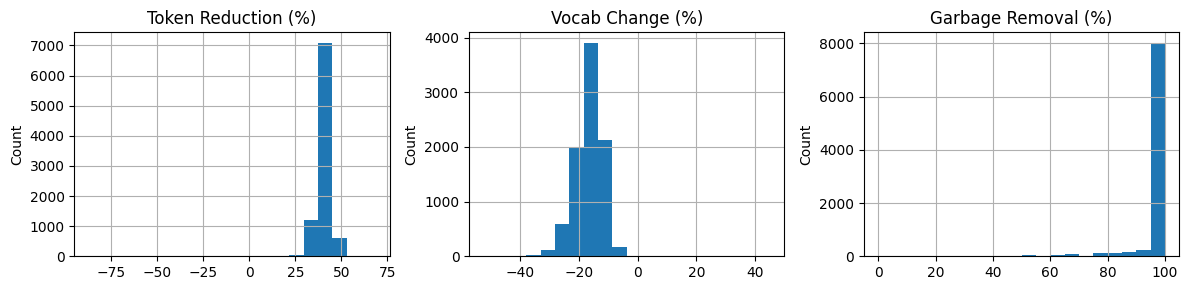

In [22]:
# %%
import re
import pandas as pd
import matplotlib.pyplot as plt

# Reuse the same 20% sample indices (idxs) and token_lists from §§5–6
raw_token_lists   = [train_ds[i]["document"].split() for i in idxs]
clean_token_lists = token_lists  # cleaned_docs split into tokens

stats = []
for raw, clean in zip(raw_token_lists, clean_token_lists):
    raw_count   = len(raw)
    clean_count = len(clean)
    reduction   = (raw_count - clean_count) / raw_count if raw_count else 0.0

    raw_vocab   = set(raw)
    clean_vocab = set(clean)
    vocab_change = (len(clean_vocab) - len(raw_vocab)) / len(raw_vocab) if raw_vocab else 0.0

    garbage_raw   = sum(1 for tok in raw   if not re.search(r"[A-Za-z0-9]", tok))
    garbage_clean = sum(1 for tok in clean if not re.search(r"[A-Za-z0-9]", tok))
    garbage_removal = (garbage_raw - garbage_clean) / garbage_raw if garbage_raw else 0.0

    stats.append({
        'reduction_pct':       reduction * 100,
        'vocab_change_pct':    vocab_change * 100,
        'garbage_removed_pct': garbage_removal * 100
    })

df_clean = pd.DataFrame(stats)

# Descriptive statistics
print(df_clean.describe().loc[['mean','50%','min','max','std']])

# Plot histograms
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
df_clean['reduction_pct'].hist(bins=20, ax=axes[0]); axes[0].set_title('Token Reduction (%)')
df_clean['vocab_change_pct'].hist(bins=20, ax=axes[1]); axes[1].set_title('Vocab Change (%)')
df_clean['garbage_removed_pct'].hist(bins=20, ax=axes[2]); axes[2].set_title('Garbage Removal (%)')
for ax in axes:
    ax.set_xlabel('')
    ax.set_ylabel('Count')
plt.tight_layout()
plt.show()


## 9 – Effect of Sentence Deduplication

Quantify how many sentences are removed by:
- **Exact deduplication**  
- **Fuzzy deduplication** (Jaccard threshold = 0.5)

Use the same 20% sample to compute:
- Average sentences before/after dedup  
- Distribution of sentences removed per document  
- Plot histograms of removal counts  


      exact_removed  fuzzy_removed
mean       1.842228       4.186013
50%        0.000000       1.000000
min        0.000000       0.000000
max      496.000000     576.000000
std       12.686852      15.809517


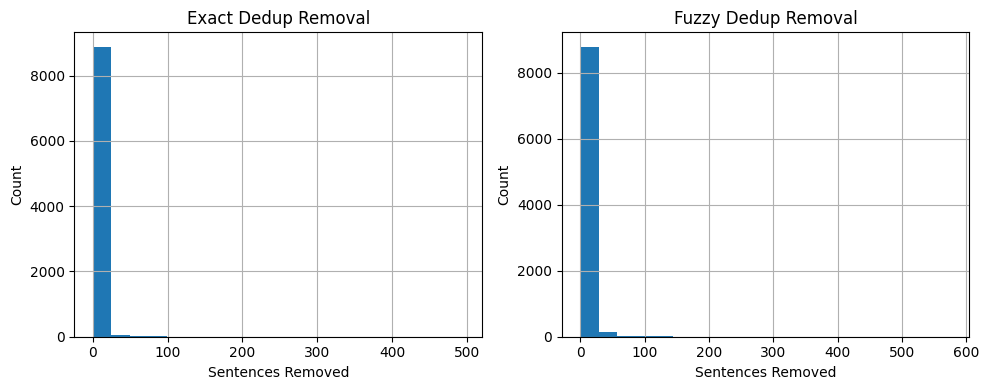

In [23]:
# %%
from nltk.tokenize import sent_tokenize
import pandas as pd
import matplotlib.pyplot as plt
from src.utils import dedup_sentences_fuzzy

# reuse docs_sample from §7
exact_removed = []
fuzzy_removed = []
total_sentences = []

for doc in docs_sample:
    sents = sent_tokenize(doc)
    total = len(sents)
    total_sentences.append(total)

    # exact dedup
    seen = set()
    out_exact = []
    for s in sents:
        key = s.strip().lower()
        if key not in seen:
            seen.add(key)
            out_exact.append(s)
    exact_removed.append(total - len(out_exact))

    # fuzzy dedup
    deduped = dedup_sentences_fuzzy(doc, threshold=0.5)
    fuzzy_count = len(sent_tokenize(deduped))
    fuzzy_removed.append(total - fuzzy_count)

df_dedup = pd.DataFrame({
    "total_sents": total_sentences,
    "exact_removed": exact_removed,
    "fuzzy_removed": fuzzy_removed
})

# descriptive stats
print(df_dedup[["exact_removed", "fuzzy_removed"]]
      .describe().loc[['mean','50%','min','max','std']])

# plot histograms
fig, axes = plt.subplots(1, 2, figsize=(10,4))
df_dedup['exact_removed'].hist(bins=20, ax=axes[0])
axes[0].set_title('Exact Dedup Removal')
df_dedup['fuzzy_removed'].hist(bins=20, ax=axes[1])
axes[1].set_title('Fuzzy Dedup Removal')
for ax in axes:
    ax.set_xlabel('Sentences Removed')
    ax.set_ylabel('Count')
plt.tight_layout()
plt.show()


## 10 – Input Window Coverage

For each of the maximum input lengths \{1 000, 2 000, 4 096\}, compute the fraction of sampled documents whose tokenized length (after cleaning) is no greater than the limit (i.e. fully preserved). Plot the coverage versus input length.


   max_input_length  fraction_preserved
0              1000            0.631310
1              2000            0.895931
2              4096            0.981099


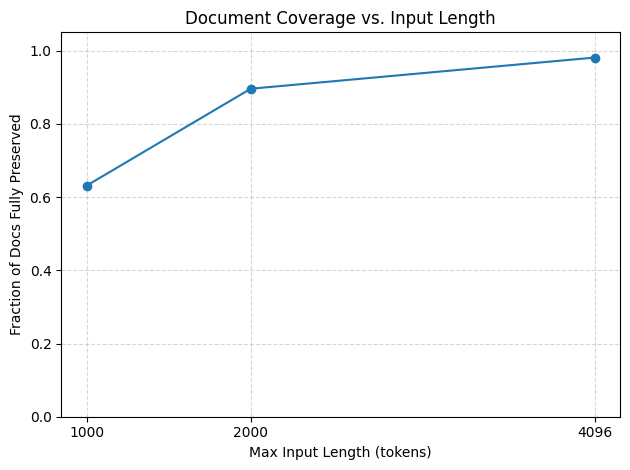

In [24]:
# %%
import pandas as pd
import matplotlib.pyplot as plt

# Define the input-length thresholds to test
limits = [1000, 2000, 4096]

# Compute fraction of documents fully preserved at each limit
fractions = []
for limit in limits:
    preserved = sum(1 for tokens in token_lists if len(tokens) <= limit)
    fractions.append(preserved / len(token_lists))

# Tabulate results
coverage_df = pd.DataFrame({
    "max_input_length": limits,
    "fraction_preserved": fractions
})
print(coverage_df)

# Plot coverage curve
plt.figure()
plt.plot(limits, fractions, marker='o')
plt.title("Document Coverage vs. Input Length")
plt.xlabel("Max Input Length (tokens)")
plt.ylabel("Fraction of Docs Fully Preserved")
plt.xticks(limits)
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## 11 – Correlation Plots

Examine relationships on the 20% sample:
- Document length vs.\ sentence duplication rate  
- Document length vs.\ compression ratio  


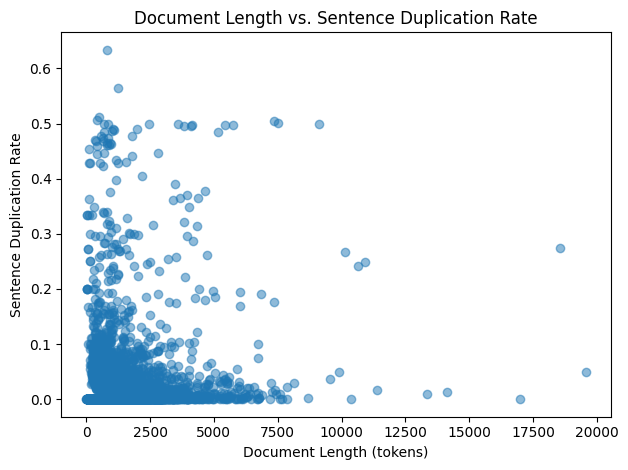

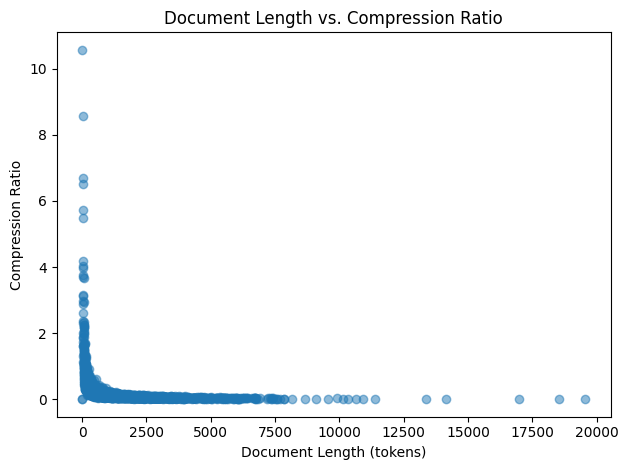

In [25]:
# %%
from src.utils import clean_text
import matplotlib.pyplot as plt

# Prepare variables from the 20% sample
cleaned_doc_lengths = [len(tokens) for tokens in token_lists]
sent_dup_rates      = df_dup['sent_dup_rate'].tolist()

# Compute summary lengths and compression ratio
summ_tokens = [
    len(clean_text(train_ds[i]["summary"], remove_stopwords=True).split())
    for i in idxs
]
comp_ratio = [
    s / d if d > 0 else 0
    for s, d in zip(summ_tokens, cleaned_doc_lengths)
]

# Scatter: document length vs. sentence duplication
plt.figure()
plt.scatter(cleaned_doc_lengths, sent_dup_rates, alpha=0.5)
plt.title("Document Length vs. Sentence Duplication Rate")
plt.xlabel("Document Length (tokens)")
plt.ylabel("Sentence Duplication Rate")
plt.tight_layout()
plt.show()

# Scatter: document length vs. compression ratio
plt.figure()
plt.scatter(cleaned_doc_lengths, comp_ratio, alpha=0.5)
plt.title("Document Length vs. Compression Ratio")
plt.xlabel("Document Length (tokens)")
plt.ylabel("Compression Ratio")
plt.tight_layout()
plt.show()


## 12 – EDA Summary

**Key observations from the 20% sample:**
- **Lengths:**  
  – Documents: median ≈ 1 300 chars / 1 300 tokens (wide spread up to ≈ 450 k tokens)  
  – Summaries: median ≈ 1 320 chars / 221 tokens  

- **Compression ratio:**  
  – Mean ≈ 0.21; 50 %-ile ≈ 0.16; 75 %-ile ≈ 0.25  
  – Outliers up to ≈ 11× (rare extremely short docs)  

- **Token statistics:**  
  – Zipfian unigram distribution; top tokens after stopword‐removal are content words (e.g. “said”, “could”, “people”)  
  – Bi-/tri-grams reflect news clichés (e.g. “Associated Press”, “White House”, “New York Times”)

- **Redundancy:**  
  – Sentence‐duplication rate mean ≈ 1.4 %; token‐duplication ≈ 34 % (high lexical overlap)  
  – Fuzzy dedup removes ~4 sentences/doc on average vs. ~2 via exact dedup  

- **Cleaning impact:**  
  – Token counts reduced by ~40 % on average  
  – “Garbage” tokens (pure punctuation) removal ≈ 97 %  

- **Input coverage:**  
  – With max_input=1 000 tokens, ~63 % of docs fully preserved  
  – At 4 096 tokens, ≈ 98 % preserved  

- **Correlations:**  
  – Longer docs → slightly lower compression ratios  
  – Higher sentence‐duplication weakly correlates with longer inputs  

These results validate our cleaning & deduplication pipeline, inform model input‐length choices, and set expectations for summarization performance.  


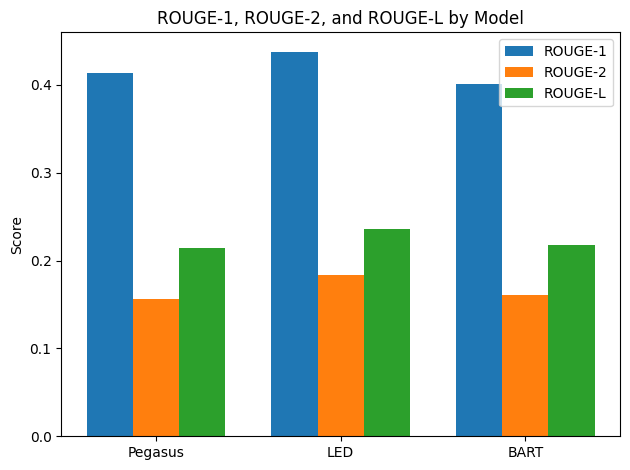

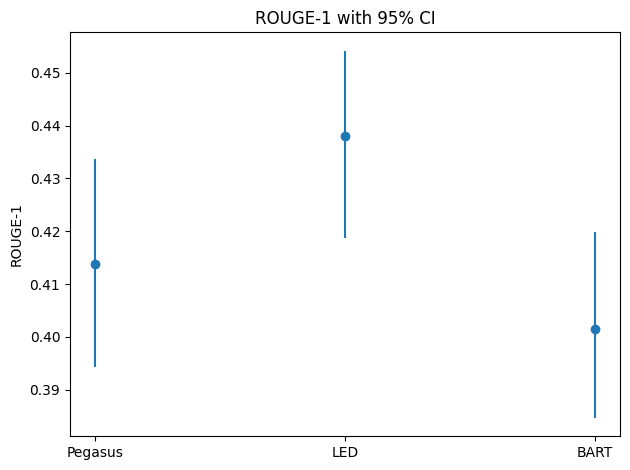

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['Pegasus', 'LED', 'BART']
rouge1 = [0.41385668, 0.43798276, 0.40157592]
rouge2 = [0.15590928, 0.18344338, 0.16073463]
rougeL = [0.21422165, 0.23551109, 0.21809438]
# ROUGE-1 CI
ci_lower = [0.39434473, 0.41874151, 0.38466749]
ci_upper = [0.43378121, 0.45419425, 0.41994898]
err_low = np.array(rouge1) - np.array(ci_lower)
err_high = np.array(ci_upper) - np.array(rouge1)

# Grouped bar chart for ROUGE
x = np.arange(len(models))
width = 0.25

plt.figure()
plt.bar(x - width, rouge1, width)
plt.bar(x, rouge2, width)
plt.bar(x + width, rougeL, width)
plt.xticks(x, models)
plt.ylabel('Score')
plt.title('ROUGE-1, ROUGE-2, and ROUGE-L by Model')
plt.legend(['ROUGE-1','ROUGE-2','ROUGE-L'])
plt.tight_layout()
plt.show()

# Error‐bar plot for ROUGE-1
plt.figure()
plt.errorbar(models, rouge1, yerr=[err_low, err_high], fmt='o')
plt.ylabel('ROUGE-1')
plt.title('ROUGE-1 with 95% CI')
plt.tight_layout()
plt.show()
